In [1]:
import sys

# Add the directory containing fs.py to the Python path
sys.path.append('./modules')

# Assuming FuzzySystemLayer and create_fuzzy_model are defined in fs.py
from fs import FuzzySystemLayer, create_fuzzy_model


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

# Paths to the prepped data files
base_path = './daily_data/'  # Adjusted base path to where our files are now
X_train_path = base_path + 'X_train.csv'
X_test_path = base_path + 'X_test.csv'
y_train_path = base_path + 'y_train.csv'
y_test_path = base_path + 'y_test.csv'

# Loading the datasets
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Convert columns to numeric, coercing errors to NaN
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Initialize the scaler for the features
scaler_X = MinMaxScaler()

# Scale 'X' features
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize a separate scaler for the target variable
scaler_y = MinMaxScaler()

# Scale 'y' (the target variable)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['date' 'classification']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['date' 'classification']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


## Function to Save Models

In [3]:
import pandas as pd

# Define the path to the CSV file
csv_path = 'tables/notebook07/results.csv'

# Read the DataFrame from the CSV file
results_df = pd.read_csv(csv_path)

print("DataFrame loaded from CSV:")
print(results_df)

DataFrame loaded from CSV:
             Model          RMSE       MAPE
0        SimpleRNN   5376.405362  19.692222
1             LSTM   7692.803221  31.045403
2              GRU  11582.438217  47.736083
3  Sequential LSTM   4149.896273  16.583052
4  Timeseries LSTM   8603.788989  35.633090
5   LSTM_Optimized   5090.087262  21.061356


In [4]:
import os
import pickle
from datetime import datetime

def save_model_and_scalers(model, scaler_X, scaler_y, model_type):
    """
    Save the Keras model and scalers with a timestamp and type in a directory using pickle.

    Parameters:
    - model: The trained Keras model to be saved.
    - scaler_X: The MinMaxScaler object for the features.
    - scaler_y: The MinMaxScaler object for the target variable.
    - model_type: A string representing the type of the model (e.g., "RNN", "LSTM").
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = f"saved_models/{model_type}"  # Create a directory with the model name
    os.makedirs(save_dir, exist_ok=True)

    # Save the model
    model_filename = f"{save_dir}/{model_type}_model_{timestamp}.h5"
    model.save(model_filename)

    # Save the scalers
    scalers_filename = f"{save_dir}/{model_type}_scalers_{timestamp}.pkl"
    with open(scalers_filename, 'wb') as f:
        pickle.dump({'scaler_X': scaler_X, 'scaler_y': scaler_y}, f)

    print(f"Model saved to {model_filename}")
    print(f"Scalers saved to {scalers_filename}")

In [5]:
# Example: Using KMeans for finding cluster centers
from sklearn.cluster import KMeans

In [6]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
# Assuming FS_Regressor has been imported from the fs module


# Determine the optimal number of clusters (e.g., using domain knowledge, elbow method, etc.)
n_clusters = 3  # This is a placeholder; adjust based on our analysis

# Steps for cluster determination remain the same
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train_scaled)
cluster_centers = kmeans.cluster_centers_

# Define and train the TensorFlow-based model
model = create_fuzzy_model(input_dim=X_train_scaled.shape[1], cluster_centers=cluster_centers)
model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2)

# Save the model and scalers after training
save_model_and_scalers(model, scaler_X, scaler_y, "Fuzzy_basic")

# Predict and evaluate
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# MSE, RMSE, and MAPE calculation
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
y_test_original = y_test.values.flatten()
mape_test = np.mean(np.abs((y_test_original - y_pred) / y_test_original)) * 100

print(f"Mean Squared Error (MSE) on Test Set: {mse_test}")
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")
print(f"Mean Absolute Percentage Error (MAPE) on Test Set: {mape_test}%")

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.0267 - val_loss: 0.4574
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 0.0187 - val_loss: 0.4023
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 0.0154 - val_loss: 0.3561
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 0.0119 - val_loss: 0.3156
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 0.0109 - val_loss: 0.2812
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 0.0097 - val_loss: 0.2487
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 0.0077 - val_loss: 0.2218
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 0.0083 - val_loss: 0.1969
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - loss: 0.0065 - val_loss: 0.1744
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - loss: 0.0072 - val_loss: 0.1533
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - loss: 0.0054 - val_loss: 0.1364
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0

Model saved to saved_models/Fuzzy_basic/Fuzzy_basic_model_20240629_003719.h5
Scalers saved to saved_models/Fuzzy_basic/Fuzzy_basic_scalers_20240629_003719.pkl
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
Mean Squared Error (MSE) on Test Set: 208769106.33341032
Root Mean Squared Error (RMSE) on Test Set: 14448.844463603666
Mean Absolute Percentage Error (MAPE) on Test Set: 49.01467633619043%


In [7]:
import os
import pandas as pd

# Assuming results_df has been read in from the previous notebook
# results_df = pd.read_csv('tables/notebook06/results.csv')

# Adding the RMSE and MAPE for the Fuzzy_basic model
new_results = pd.DataFrame([{'Model': 'Fuzzy_basic', 'RMSE': rmse_test, 'MAPE': mape_test}])
results_df = pd.concat([results_df, new_results], ignore_index=True)

# Define the output directory
output_dir = 'tables/notebook08'

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Save the updated DataFrame to CSV
results_csv_path = os.path.join(output_dir, 'results.csv')
results_df.to_csv(results_csv_path, index=False)

# Save the updated DataFrame to a LaTeX table
results_latex_path = os.path.join(output_dir, 'results.tex')
with open(results_latex_path, 'w') as f:
    f.write(results_df.to_latex(index=False))

# Print the updated DataFrame
print(results_df)


             Model          RMSE       MAPE
0        SimpleRNN   5376.405362  19.692222
1             LSTM   7692.803221  31.045403
2              GRU  11582.438217  47.736083
3  Sequential LSTM   4149.896273  16.583052
4  Timeseries LSTM   8603.788989  35.633090
5   LSTM_Optimized   5090.087262  21.061356
6      Fuzzy_basic  14448.844464  49.014676


In [8]:
import pandas as pd

# Paths to the prepped data files
base_path = './daily_data/'  # Adjusted base path to where our files are now
X_test_path = base_path + 'X_test.csv'

# Re-read the X_test data from the file
X_test = pd.read_csv(X_test_path)

# Ensure the datetime column is present
if 'datetime' not in X_test.columns:
    X_test['datetime'] = pd.to_datetime(X_test.index)

print("Available columns in X_test after adding datetime:", X_test.columns)


Available columns in X_test after adding datetime: Index(['date', 'open', 'volume', 'sma_30', 'rsi', 'macd', 'dia_close',
       'dia_volume', 'gld_close', 'gld_volume', 'spy_close', 'spy_volume',
       'federal_funds_rate_daily', 'treasury_yield_daily', 'cpi_monthly',
       'durables_monthly', 'nonfarm_payroll_monthly',
       'real_gdp_per_capita_quarterly', 'real_gdp_quarterly',
       'retail_sales_monthly', 'unemployment_monthly',
       'central_bank_policy_rate_prcnt', 'domestic_credit_gdp',
       'foreign_direct_investment_value', 'gdp_growth_annual_prcnt',
       'inflation_rate_value',
       'individuals_using_the_internet_prcnt_of_population',
       'mobile_cellular_subscriptions_per_100_people',
       'personal_remittances_received_prcnt_of_gdp',
       'stock_market_index_value', 'tariffs_value',
       'total_public_debt_gdp_value', 'trade_balance_value',
       'trade_in_services_value', 'unemployment_rate_value', 'value',
       'classification_numerical', 'classi

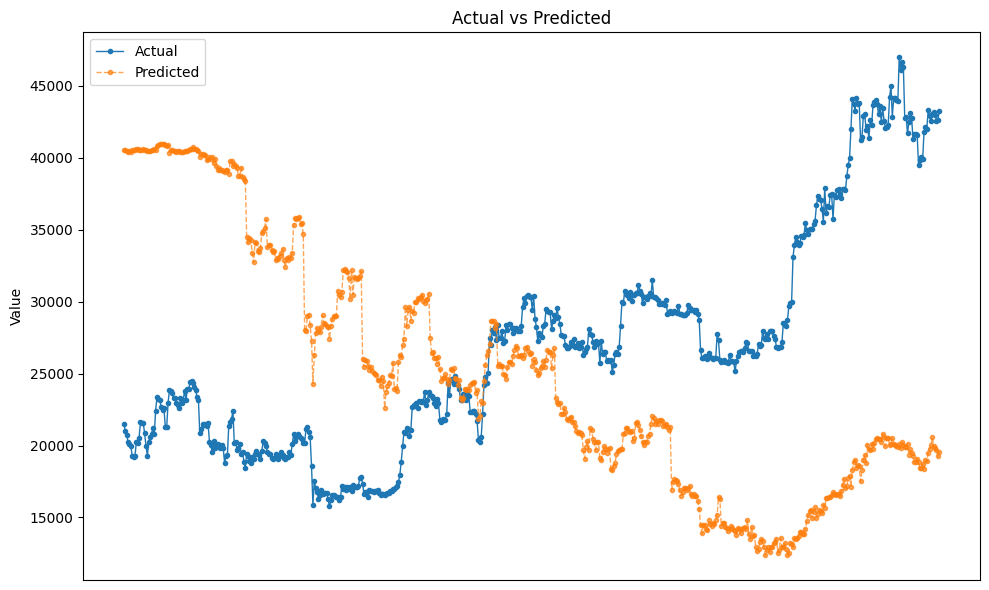

In [9]:
import matplotlib.pyplot as plt
import os

y_test_original = y_test.values.flatten()[:len(y_pred)]  # Adjust length if necessary

plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(y_pred, label='Predicted', alpha=0.7, marker='.', linestyle='--', linewidth=1)
plt.title('Actual vs Predicted')
plt.xlabel('')
plt.ylabel('Value')
plt.legend()

# Remove the x-axis ticks and labels
plt.xticks([])

plt.tight_layout()

# Save the plot to the specified directory
output_dir = 'figures/notebook08'
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, 'actual_vs_predicted08.png')
plt.savefig(plot_path, bbox_inches='tight')
plt.show()
